# **Day 2 Task**: _Customer Churn Prediction_

**Objective**: Build a machine learning model to predict customer churn in a telecom dataset. The task will focus on intermediate-level feature engineering, handling imbalanced data, and model evaluation.

In [2]:
# Importing necessary lib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,roc_curve,f1_score,precision_score,recall_score

In [4]:
#Loading the dataset and it's info

data= pd.read_csv(r'D:\Projects\Daily Projects\Customer Churn (17-02-25)\Dataset\Customer_churn_Dataset.csv')

print(data.head(3))
print(data.info())

   customerID  gender  SeniorCitizen Partner  ...     PaymentMethod  MonthlyCharges TotalCharges Churn
0  7590-VHVEG  Female              0     Yes  ...  Electronic check           29.85        29.85    No
1  5575-GNVDE    Male              0      No  ...      Mailed check           56.95       1889.5    No
2  3668-QPYBK    Male              0      No  ...      Mailed check           53.85       108.15   Yes

[3 rows x 21 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-nul

## _1. EDA (Exploratory Data Analysis)_

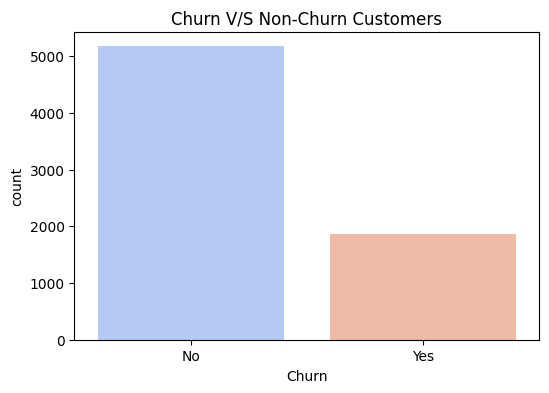

In [8]:
#Let's visualize churn distribution

plt.figure(figsize=(6,4,))
sns.countplot(x='Churn', data=data, palette='coolwarm', hue='Churn', legend=False)
plt.title('Churn V/S Non-Churn Customers')
plt.show()

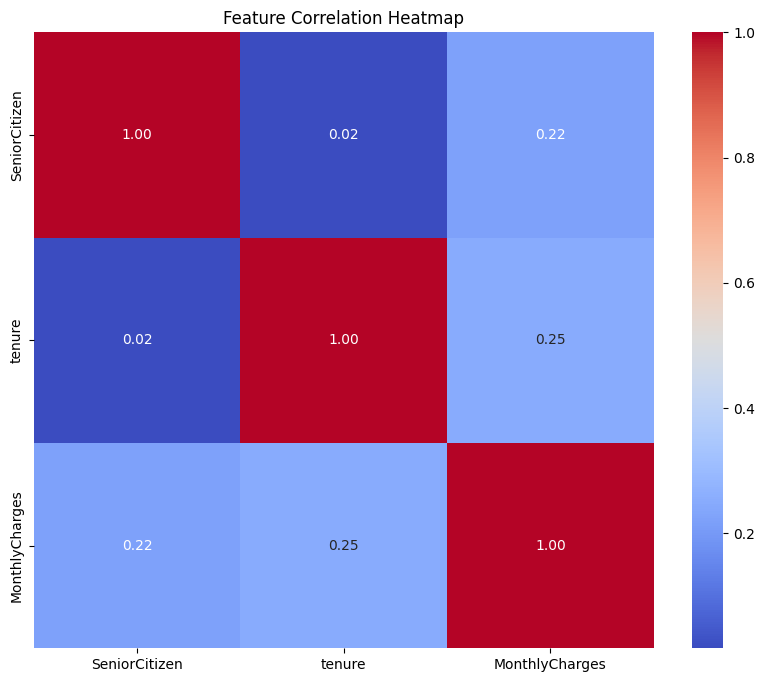

In [13]:
#let's look at the corerlation through heatmap now

plt.figure(figsize=(10, 8))
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()                                  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

## _2. Data Preprocessing_

In [15]:
data.fillna(numeric_data.median(), inplace=True)

In [16]:
# Encode categorical variables
label_encoders = {}
for col in data.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

## _3. Feature Engineering_

In [20]:
# Creating some new features
data['Tenure_Years'] = data['tenure'] / 12
data['Is_Long_Tenure'] = np.where(data['Tenure_Years'] > 1, 1, 0)
data['Avg_Monthly_Charge'] = data['TotalCharges'] / (data['tenure'] + 1)  # Avoid divide-by-zero
data['Revenue_Potential'] = data['Avg_Monthly_Charge'] * (24 - data['Tenure_Years'])
data['Services_Used'] = data[['PhoneService', 'InternetService', 'StreamingTV', 'StreamingMovies']].sum(axis=1)
data['Contract_PaymentMethod'] = data['Contract'].astype(str) + '_' + data['PaymentMethod'].astype(str)

In [19]:
# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['MonthlyCharges', 'TotalCharges', 'tenure', 'Avg_Monthly_Charge', 'Revenue_Potential']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

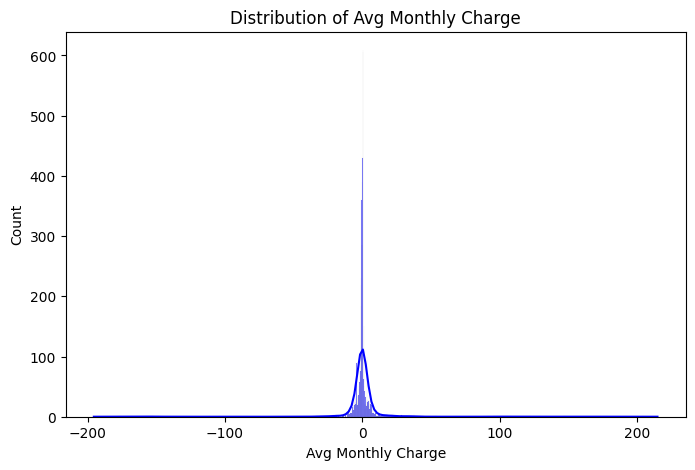

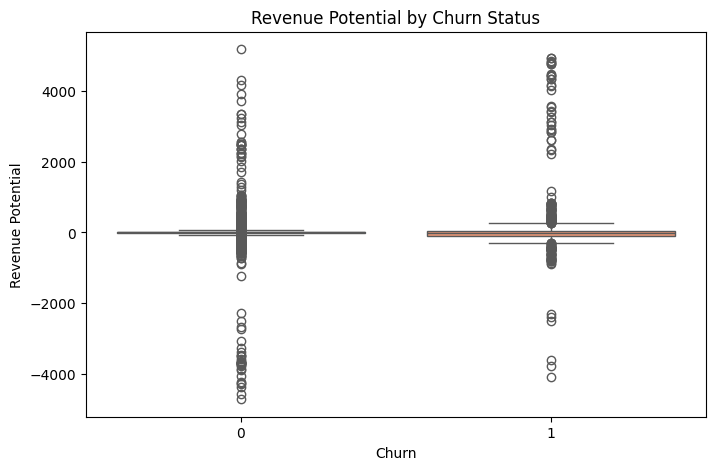

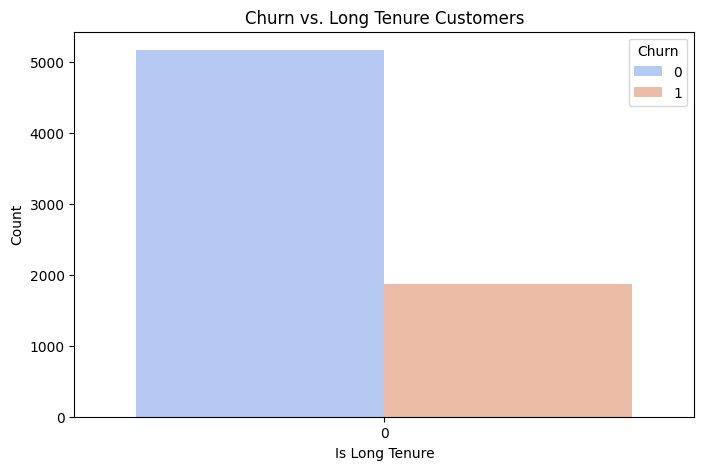

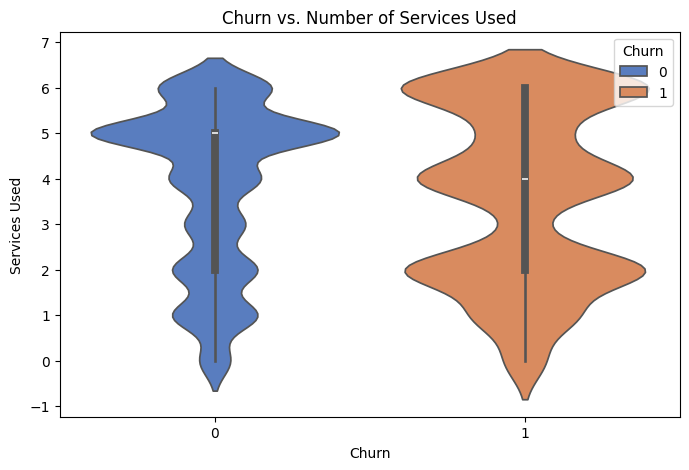

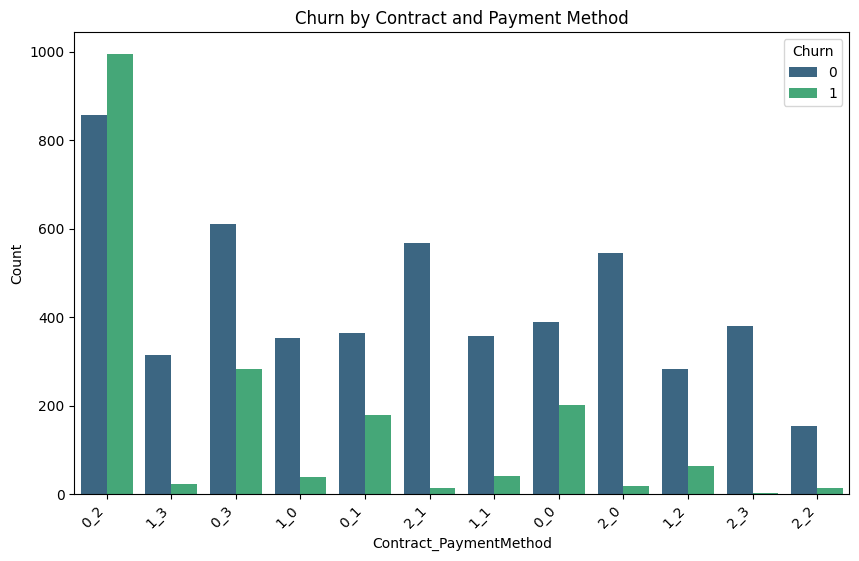

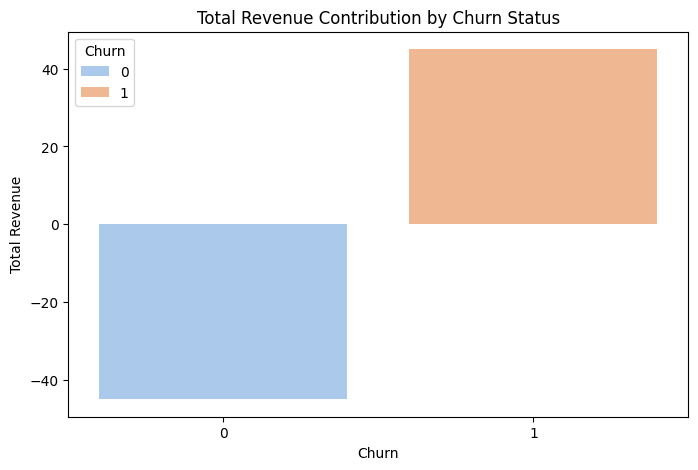

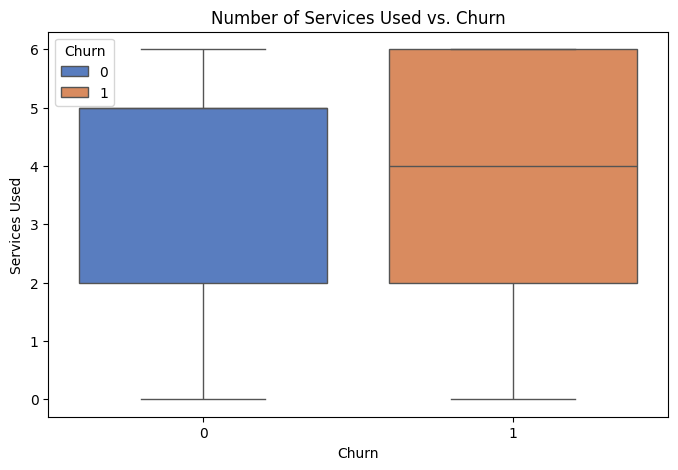

In [26]:
# Let's see some graphs by using new features that we created

# Distribution of Avg_Monthly_Charge
plt.figure(figsize=(8, 5))
sns.histplot(data['Avg_Monthly_Charge'], kde=True, color='blue')
plt.title('Distribution of Avg Monthly Charge')
plt.xlabel('Avg Monthly Charge')
plt.show()

# Boxplot for Revenue_Potential
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['Churn'], y=data['Revenue_Potential'], palette='Set2', hue=data['Churn'], legend=False)
plt.title('Revenue Potential by Churn Status')
plt.xlabel('Churn')
plt.ylabel('Revenue Potential')
plt.show()

# Countplot for Is_Long_Tenure
plt.figure(figsize=(8, 5))
sns.countplot(x='Is_Long_Tenure', hue='Churn', data=data, palette='coolwarm')
plt.title('Churn vs. Long Tenure Customers')
plt.xlabel('Is Long Tenure')
plt.ylabel('Count')
plt.show()

# Violin plot for Services Used
plt.figure(figsize=(8, 5))
sns.violinplot(x='Churn', y='Services_Used', data=data, palette='muted', hue='Churn', legend=True)
plt.title('Churn vs. Number of Services Used')
plt.xlabel('Churn')
plt.ylabel('Services Used')
plt.show()

# Bar plot for Churn across Contract_PaymentMethod
plt.figure(figsize=(10, 6))
sns.countplot(x='Contract_PaymentMethod', hue='Churn', data=data, palette='viridis')
plt.title('Churn by Contract and Payment Method')
plt.xlabel('Contract_PaymentMethod')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


# Revenue contribution by churn
revenue_churn = data.groupby('Churn')['TotalCharges'].sum().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='Churn', y='TotalCharges', data=revenue_churn, palette='pastel', hue='Churn', legend=True)
plt.title('Total Revenue Contribution by Churn Status')
plt.xlabel('Churn')
plt.ylabel('Total Revenue')
plt.show()

# Services Used vs. Churn
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn', y='Services_Used', data=data, palette='muted', hue='Churn', legend= True)
plt.title('Number of Services Used vs. Churn')
plt.xlabel('Churn')
plt.ylabel('Services Used')
plt.show()

## _4. Handling Imbalanced Data_

In [27]:
# Split data into features and target
X = data.drop(columns=['Churn'])
y = data['Churn']

In [28]:
# SMOTE for handling imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

## _5. Modeling_

In [30]:
# Split resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [35]:
# Logistic Regression
log_model = LogisticRegression(solver='liblinear', max_iter=500)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

In [38]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [44]:
label_encoder = LabelEncoder()

# Fit the encoder on the training data and transform both training and test data
X_train['Contract_PaymentMethod'] = label_encoder.fit_transform(X_train['Contract_PaymentMethod'])
X_test['Contract_PaymentMethod'] = label_encoder.transform(X_test['Contract_PaymentMethod'])

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

## _6. Evaluation_

In [45]:
#Evaluation function
def evaluate_model(y_test, y_pred, model_name):
    print(f"\n=== {model_name} ===")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

# Evaluate Logistic Regression
evaluate_model(y_test, y_pred_log, "Logistic Regression")

# Evaluate Random Forest
evaluate_model(y_test, y_pred_rf, "Random Forest")

# Evaluate XGBoost
evaluate_model(y_test, y_pred_xgb, "XGBoost")


=== Logistic Regression ===
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1021
           1       0.83      0.87      0.85      1049

    accuracy                           0.84      2070
   macro avg       0.85      0.84      0.84      2070
weighted avg       0.85      0.84      0.84      2070

Confusion Matrix:
[[836 185]
 [137 912]]
ROC-AUC Score: 0.8441022605363628

=== Random Forest ===
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1021
           1       0.86      0.86      0.86      1049

    accuracy                           0.85      2070
   macro avg       0.85      0.85      0.85      2070
weighted avg       0.85      0.85      0.85      2070

Confusion Matrix:
[[869 152]
 [152 897]]
ROC-AUC Score: 0.8531132210238938

=== XGBoost ===
Classification Report:
              precision    recall  f1-score   support

   

## _7. Visualization_

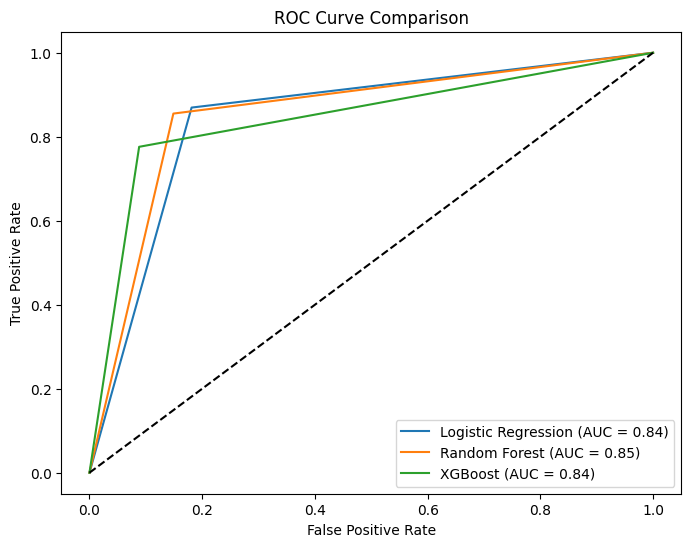

In [46]:
# Plot ROC Curve for comparison
plt.figure(figsize=(8, 6))
for model, y_pred, label in zip(
    [log_model, rf_model, xgb_model],
    [y_pred_log, y_pred_rf, y_pred_xgb],
    ["Logistic Regression", "Random Forest", "XGBoost"]
):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_score(y_test, y_pred):.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
